# xgboost regressor experience

### library settting

In [221]:
import os
import datetime
from xgboost import XGBRegressor
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### data loading

In [232]:
# train_x와 train_y merging한 파일
df = pd.read_hdf('./data/merged_data.h5')

# 임의로 sample_id 1000까지는 train으로 이후는 test로 구분지어 둠.
train_df = df[df.sample_id <= 1000]
test_df = df[df.sample_id > 1000]

# window size 지정
n_steps = 6

### data preprocessing 
open 데이터를 지정한 window 만큼 보고 다음 값을 예측
window pararmeter : n_step

In [223]:
def split_sequence(dataframe, n_steps = n_steps):

    ''' 설명 생략 '''

    # grouping
    grouped_df = dataframe.groupby('sample_id')
    
    # export unique sample ids
    unique_sample_id_list = grouped_df.sample_id.unique()

    # create new lists
    X, y = list(), list()

    # get one group & split sequence
    for sample_id in unique_sample_id_list:
        
        # get one sample_id in sample list
        temp_sample_id = sample_id.item()

        # get one group by temp_sample_id
        temp_df = grouped_df.get_group(temp_sample_id)

        # get open price series in selected group
        temp_series = temp_df.open.values

        # in one dataframe loop
        for idx in range(len(temp_series)):

            # find the end of this pattern
            end_idx = idx + n_steps

            # check if we are beyond the sequence
            if end_idx > len(temp_series)-1:
                break

            # gather input and output parts of the pattern
            seq_x, seq_y = temp_series[idx:end_idx], temp_series[end_idx]

            X.append(seq_x)
            y.append(seq_y)
    
    
    # creat new dataframe
    col_list = list()

    for i in range(n_steps, 0,-1):
        name = f'x-{i}'
        col_list.append(name)
    
    new_df = pd.DataFrame(X, columns = col_list)
    new_df['y'] = y
    
    return new_df

In [225]:
preprocessed_train_df = split_sequence(dataframe = train_df, n_steps = n_steps)

In [226]:
# 전처리 예시
preprocessed_train_df.head()

,x-6,x-5,x-4,x-3,x-2,x-1,y
0,0.983614,0.983245,0.982694,0.983009,0.984233,0.984164,0.984597
1,0.983245,0.982694,0.983009,0.984233,0.984164,0.984597,0.983986
2,0.982694,0.983009,0.984233,0.984164,0.984597,0.983986,0.983986
3,0.983009,0.984233,0.984164,0.984597,0.983986,0.983986,0.983618
4,0.984233,0.984164,0.984597,0.983986,0.983986,0.983618,0.983243


### train by xgb regressor

In [231]:
def xgboost_forecast(train_df = preprocessed_train_df ,model_save = False):
    
    ''' 설명 생략 '''

    # df to array
    train_sequence = np.array(train_df)

    # train X, y split
    trainX, trainy = train_sequence[:, :-1], train_sequence[:, -1]

    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 500)
    model.fit(trainX, trainy)

    # model save
    if model_save is True:

        model_name = "xgb_regressor.pkl"
        pickle.dump(model, open(file_name, "wb"))

    return model 

### one sample test

일단 한 샘플만 가지고 test prediction 해봄


In [236]:

test_sample_id = 1001 # 바뀐 sample id라 확인해봐야 할 듯.
test_df = test_df[test_df.sample_id == test_sample_id]

# 1380 이후만 split
test_set = test_df[test_df.time > (1500 - 121 - n_steps)]

# true y values 는 1380 이후 open value
true_y = test_set[test_set.time >= 1380].open.values
# test input은 1380 이전 n_step개 value
test_input = test_set.open[:n_steps].values

In [205]:
def targetdays_predict(test_sequence = test_input, target_len = 120):
    
    """ 마지막 시퀀스를 가지고 target len동안 모델예측을 반복함. """

    temp_X = test_sequence.reshape(1, 6)
    predictions = list()
    
    for i in range(target_len):
  

        # predict & appending
        pred_y = model.predict(temp_X)
        predictions.append(pred_y.item())
        
        # confirm
        print(f'X is {temp_X}, y is {pred_y}')
        
        # expand pred_y dims (1, ) to (1, 1)
        temp_y = np.expand_dims(pred_y, axis = 1)

        # appending pred_y to temp_X and delete oldest value in temp_X
        temp_X = np.append(temp_X, temp_y, axis = 1)
        temp_X = np.delete(temp_X, 0, axis = 1)

    return predictions

In [237]:
# prediction
pred_y = targetdays_predict(test_input, 120)

X is [[0.99514079 0.99029416 0.99291998 0.99465895 0.99913901 1.        ]], y is [0.999557]
X is [[0.99029416 0.99291998 0.99465895 0.99913901 1.         0.99955702]], y is [0.99942446]
X is [[0.99291998 0.99465895 0.99913901 1.         0.99955702 0.99942446]], y is [0.9993036]
X is [[0.99465895 0.99913901 1.         0.99955702 0.99942446 0.99930358]], y is [0.9991888]
X is [[0.99913901 1.         0.99955702 0.99942446 0.99930358 0.99918878]], y is [0.9992742]
X is [[1.         0.99955702 0.99942446 0.99930358 0.99918878 0.99927419]], y is [0.9993304]
X is [[0.99955702 0.99942446 0.99930358 0.99918878 0.99927419 0.9993304 ]], y is [0.9993909]
X is [[0.99942446 0.99930358 0.99918878 0.99927419 0.9993304  0.9993909 ]], y is [0.9993909]
X is [[0.99930358 0.99918878 0.99927419 0.9993304  0.9993909  0.9993909 ]], y is [0.9993909]
X is [[0.99918878 0.99927419 0.9993304  0.9993909  0.9993909  0.9993909 ]], y is [0.9993909]
X is [[0.99927419 0.9993304  0.9993909  0.9993909  0.9993909  0.999390

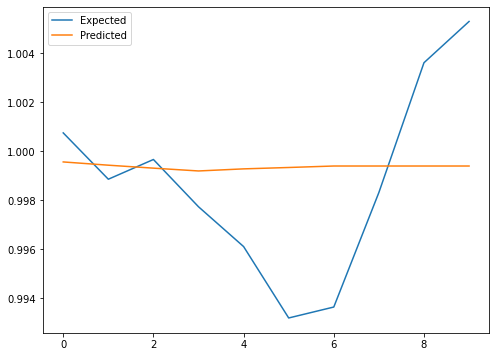

<Figure size 576x432 with 0 Axes>

In [210]:

# plot expected vs preducted
plt.plot(true_y[:10], label='Expected')
plt.plot(pred_y[:10], label='Predicted')
plt.legend()
plt.show()

plt.savefig('./xgboost_exp1')

### targetdays_predict function for loop logic example

In [184]:
temp_X = test_input.reshape(1, 6)
print(
    f'''
    first X series is {temp_X}
    current X dims is {temp_X.shape}
    '''
    )

temp_y = model.predict(temp_X)

print(
    f'''
    pred y is {temp_y}
    current y dims is {temp_y.shape}
    expanded y dims i s{np.expand_dims(temp_y, axis = 1).shape}
    '''
)

temp_X2 = np.append(temp_X, np.expand_dims(temp_y, axis = 1), axis = 1)
print(
    f'''
    temp X2 series is {temp_X2}
    current X dims is {temp_X2.shape}
    next X series is {temp_X2[:,1:]}
    next X dims is {temp_X2[:, 1:].shape}
    '''
)



    first X series is [[0.99514079 0.99029416 0.99291998 0.99465895 0.99913901 1.        ]]
    current X dims is (1, 6)
    

    pred y is [0.999557]
    current y dims is (1,)
    expanded y dims i s(1, 1)
    

    temp X2 series is [[0.99514079 0.99029416 0.99291998 0.99465895 0.99913901 1.
  0.99955702]]
    current X dims is (1, 7)
    next X series is [[0.99029416 0.99291998 0.99465895 0.99913901 1.         0.99955702]]
    next X dims is (1, 6)
    
